<a href="https://colab.research.google.com/github/dmswl0707/transfer-learning_pytorch/blob/main/setting_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#image_net사용
#classifier만 변형

from __future__ import print_function, division
#주석필요

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler #학습률수정?
from torch.autograd import Variable #grad 주석 필요
import numpy as np
import torchvision
from torchvision import datasets, models, transforms #데이터셋,모델,변형
import matplotlib.pyplot as plt 
import time #주석필요
import os #시스템 주석필요
import copy

plt.ion() #interactive model


model_name="resnet"
num_classes=2
batch_size=8
num_epochs=15
feature_extract=True


#########데이터로드##############

##데이터 불러오기-torchvision, torch.utils.data

###학습을 위한 데이터 증가(augmentation)과 일반화하기
data_transform={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #주석
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


from google.colab import drive
drive.mount('/content/drive')
data_dir='/content/drive/My Drive/Colab Notebooks/data/hymenoptera_data'



image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


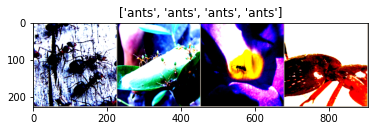

In [ ]:
###이미지 예제 시각화

def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0)) #
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std+inp+mean
    inp = np.clip(inp, 0, 1) #clip 함수
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #업데이트하기 위해 잠시 멈충

inputs, classes = next(iter(dataloaders['train']))

out=torchvision.utils.make_grid(inputs) #배치 가져오기

imshow(out,title=[class_names[x] for x in classes]) #그리드 만들기

In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #
    
    best_model_wts=copy.deepcopy(model.state_dic()) #
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('_'*10)
        
        #each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                schedular.step()   #
                model.train(True)
            else:
                model.train(False) #model.eval()

            running_loss=0.0
            running_corrects=0 #
            
            #Iterate over data
            for data in dataloaders[phase]:
                inputs, label = data
                #inputs=inputs.to(device)
                #labels=labels.to(device)

                if use_gpu:
                    inputs = Variable(inputs.cuda()) 
                    labels = Variable(labels.cuda()) 
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad() #

                #forward
                outputs=model(inputs)
                _, preds = torch.max(outputs.data, 1) #
                loss=criterion(outputs, labels) #

                #backward + optimize if only tranining
                if phase=='train':
                    loss.backward()
                    optimizer.step()

                running_loss +=loss.data[0]*inputs.size(0)
                running_corrects +=torch.sum(preds==labels.data) #
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #

        print()

    time_elapsed = time.time() - since #
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)
    

In [ ]:
######모델 매개 변수의 .requires_grad 속성 설정 ####

def set_parameter_rwquires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False  #pretraind된 매개변수를 사용

In [ ]:
###########네트워크 초기화 및 재구성 #######

#(fc) : Linear(in_features=512, out_features=1000, bias=True)
#model.fc=nn.Linear(512, num_classes)
#기존 모델의 classifier가 fc로 되어있음, 512개의 입력기능과 2개의 출력기능이 있는 선형계층을 초기화

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft=None
    input_size=0

    model_name = 'resnet'
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract) #
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes=2)
    input_size=224

    return model_ft, input_size


model_ft, input_size = initialize_model(model_name, num_classes, feature_extract,use_pretrained=True)
print(model_ft)





Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


NameError: ignored

In [ ]:
#######optimizer 생성

model_ft=model_ft.to(device)

param_to_update=model_ft.parameters()
print("param to learn")

if feature_extract:
    params_to_update=[]
    for name, param in model_ft.named_parameters():
        if param.requires_grad==True:
            param_to_update.append(param)
            print("\t", name)

else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)

optimizer_ft=optim.SGD(params_to_update, lr=0.001, momentum=0.9)




In [ ]:
######training and val


criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, criterion, optimizer_ft, num_epochs=num_epochs)